# Processor tutorial

This tutorial describes the data class / processor design pattern and guides you on how to turn existing code into a processing chain (with all the added benefits like single or parallel batch processing).

It assumes that you have finished/understood the [onset_detection notebook](./onset_detection.ipynb), since that notebook covers the code we want to transfer into a processing chain.

In [1]:
%matplotlib inline

import madmom
import numpy as np
import matplotlib.pyplot as plt

Remember on how we obtained the `SuperFlux` onset detection function from an audio file (explicitly formulating every single step):

In [2]:
sig = madmom.audio.signal.Signal('data/sample.wav')
fs = madmom.audio.signal.FramedSignal(sig)
stft = madmom.audio.stft.ShortTimeFourierTransform(fs)
spec = madmom.audio.spectrogram.Spectrogram(stft)
filt = madmom.audio.spectrogram.FilteredSpectrogram(spec, num_bands=24)
log = madmom.audio.spectrogram.LogarithmicSpectrogram(filt)
diff = madmom.audio.spectrogram.SpectrogramDifference(log, diff_max_bins=3, positive_diffs=True)
superflux_1 = np.mean(diff, axis=1)

We already know that it would have been enough to do:

In [3]:
spec = madmom.audio.spectrogram.LogarithmicFilteredSpectrogram('data/sample.wav', num_bands=24)
diff = madmom.audio.spectrogram.SpectrogramDifference(spec, diff_max_bins=3, positive_diffs=True)
superflux_2 = np.mean(diff, axis=1)

Anyways, our goal is to be able to perform the same task as above for different audio files without much work.
A simple solution would be to iterate over the audio files and save everything accordingly, or to define a class which does exactly the same as above in a method.

In [4]:
class SimpleSuperFluxProcessing(object):
    
    def process(data):
        spec = madmom.audio.spectrogram.LogarithmicFilteredSpectrogram(data, num_bands=24)
        diff = madmom.audio.spectrogram.SpectrogramDifference(spec, diff_max_bins=3, positive_diffs=True)
        return np.mean(diff, axis=1)

This works as desired, but we are not able to set any parameters, e.g. the number of bands used for the filtering step. To be able to do so, we would need to save the parameters that we want to be able to change.

In [5]:
class BetterSuperFluxProcessing(object):
    
    def __init__(self, num_bands=24, diff_max_bins=3, positive_diffs=True):
        self.num_bands = num_bands
        self.diff_max_bins = diff_max_bins
        self.positive_diffs = positive_diffs
        
    def process(data):
        spec = madmom.audio.spectrogram.LogarithmicFilteredSpectrogram(data, num_bands=self.num_bands)
        diff = madmom.audio.spectrogram.SpectrogramDifference(diff, diff_max_bins=self.diff_max_bins,
                                                              positive_diffs=self.positive_diffs)
        return np.mean(diff, axis=1)
    

This variant is able to set the number of bins and the other parameters and then process the audio files accordingly, but of course there's a better way to accomplish the same functionality.

## Processors

`madmom` offers a *processor class* for any *data class* (we call them data classes, because an object of this class depends on the input data). E.g. there's a `madmom.audio.signal.SignalProcessor()` class for the `madmom.audio.signal.Signal()`class.

Both data and processor classes accept the same arguments, the only difference is that the processor class misses the first argument of the corresponing data class. E.g. the `Signal` class expects a file name as the first argument but the `SignalProcessor` class misses exactly this first argument. Please note that the processor classes may provide additional keyword arguments and add more functionality, but always reflect at least the arguments and functionality of the data class.

All processor classes inherit from the `madmom.processors.Processor` base class and must provide a `process()` method which accepts the data to be processed as the first argument. When called, it process the given data according to the defined processing and returns the processed data.

These two are equivalent and return the exact same data.

In [6]:
madmom.audio.signal.Signal('data/sample.wav')

Signal([-2494, -2510, -2484, ...,   520,   655,   639], dtype=int16)

In [7]:
madmom.audio.signal.SignalProcessor().process('data/sample.wav')

Signal([-2494, -2510, -2484, ...,   520,   655,   639], dtype=int16)

Additionally, every `Processor` is callable, so we could also do this instead (more on this later):

In [8]:
madmom.audio.signal.SignalProcessor()('data/sample.wav')

Signal([-2494, -2510, -2484, ...,   520,   655,   639], dtype=int16)

Using processors, the `SuperFlux` algorithm could be rewritten as:

In [9]:
spec = madmom.audio.spectrogram.LogarithmicFilteredSpectrogramProcessor(num_bands=24).process('data/sample.wav')
diff = madmom.audio.spectrogram.SpectrogramDifferenceProcessor(diff_max_bins=3, positive_diffs=True).process(spec)
superflux_3 = np.mean(diff, axis=1)

This is basically still the same as before. The second processor uses the output of the first and processes it further. It still does not provide any benefits compared to the simpler versions without any processors.

### SequentialProcessor

To sequentiall process the output of any processor by another processor, `madmom` offers the `SequentialProcessor` class, which does exactly this. To create a `SequentialProcessor`, simply pass a list of processors to the constructor. When the `process()` method or the processor itself is called, it processes all processors sequantially, feeding the output of one processor to the next one as input.

Exploiting the fact that the `Processors` must be callable and the `SequentialProcessor` calls them rather calling the `process()` method, we can use any function as a processor as long as it accepts a single argument. We can thus rewrite the `SuperFlux` as a `SequentialProcessor`:

In [10]:
spec = madmom.audio.spectrogram.LogarithmicFilteredSpectrogramProcessor(num_bands=24)
diff = madmom.audio.spectrogram.SpectrogramDifferenceProcessor(diff_max_bins=3, positive_diffs=True)
# functions can also be used as processors!
from functools import partial
mean = partial(np.mean, axis=1)

superflux_seq_processor = madmom.processors.SequentialProcessor([spec, diff, mean])

Or since classes are so nice and the parameters can be changed easily as a class inheriting from `SequentialProcessor`:

In [11]:
class SuperFluxProcessor(madmom.processors.SequentialProcessor):
    
    def __init__(self, num_bands=24, diff_max_bins=3, positive_diffs=True):
        # define the processing chain
        spec = madmom.audio.spectrogram.LogarithmicFilteredSpectrogramProcessor(num_bands=num_bands)
        diff = madmom.audio.spectrogram.SpectrogramDifferenceProcessor(diff_max_bins=diff_max_bins,
                                                                       positive_diffs=positive_diffs)
        from functools import partial
        mean = partial(np.mean, axis=1)
        # sequentially process everything
        super(SuperFluxProcessor, self).__init__([spec, diff, mean])
        
superflux_processor = SuperFluxProcessor()

Check that they are equivalent:

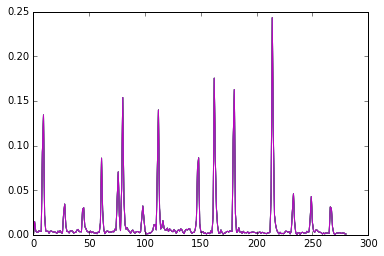

In [12]:
superflux_4 = superflux_seq_processor.process('data/sample.wav')
superflux_5 = superflux_processor.process('data/sample.wav')

plt.figure()
plt.plot(superflux_1)
plt.plot(superflux_2)
plt.plot(superflux_3)
plt.plot(superflux_4)
plt.plot(superflux_5)

Additionally there are a couple of other processors defined:

### ParallelProcessor

Accepts a list of processors, processes the given data with all of them (in parallel) and returns a list with the results.

### OutputProcessor

A Processor whose `process()` method accepts two arguments (input and output). It processes the 'input', puts it into 'output' and returns it. Used for writing something to a file.

### IOProcessor

Accepts two arguments, an `in_processor` and an `out_processor`. The former can be a single `Processor`, a `SequentialProcessor`, a function accepting a single argument. If a list is given, it gets wraped as a `SequentialProcessor`. The latter can be an `OutputProcessor` or a function which accepts two arguments (input and output).

## What are the benefits of using `Processor`s?

### Single / batch processing

The `madmom.processors` module also offers functions for processing any processor either with a single file or a list of files.

The `madmom.processors.process_single(processor, infile, outfile)` function processes the `infile` and saves/pipes the processed data to `outfile`.

The `madmom.processors.process_batch(processor, files, output_dir, num_workers)` (some arguments omitted) function processes the `files` and saves the processed data to `output_dir`. It automatically spawns multiple workers and processes all files in parallel.

### Pickling of processors

All processors can be pickled, i.e. all parameters are saved and can be loaded at any time to get the exact same results. This can be used to reproduce the exact same results of an experiment later on.